In [1]:
import optuna

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

import idlmam

In [2]:
if torch.backends.mps.is_available(): 
    device = torch.device("mps") 
else:
    device = torch.device("cpu")

In [3]:
D = 28 * 28
n = 2 
C = 1 
classes = 10 

In [4]:
class TransposeLinear(nn.Module):                    
    def __init__(self, linearLayer, bias=True):

        """ 
        linearLayer: is the layer that we want to use the transpose of to 
        ➥ produce the output of this layer. So the Linear layer represents 
        ➥ W, and this layer represents W^T. This is accomplished via 
        ➥ weight sharing by reusing the weights of linearLayer 
        bias: if True, we will create a new bias term b that is learned 
        separately from what is in 
        linearLayer. If false, we will not use any bias vector. 
        """ 

        super().__init__() 
        self.weight = linearLayer.weight                

        if bias: 
            self.bias = nn.Parameter(torch.Tensor(
                                    linearLayer.weight.shape[1]))           


        else:
            self.register_parameter('bias', None)      


    def forward(self, x):                              
        return F.linear(x, self.weight.t(), self.bias) 

In [5]:
linearLayer = nn.Linear(D, n, bias=False)

pca_encoder = nn.Sequential(
    nn.Flatten(), linearLayer,
)

pca_decoder = nn.Sequential(
    TransposeLinear(linearLayer, bias=False),
    idlmam.View((-1, 1, 28, 28)),
)

pca_model = nn.Sequential(
    pca_encoder, 
    pca_decoder
)


To make it truly PCA, we need to add the WW⊤ = I constraint, orthogonality. 

In [6]:
nn.init.orthogonal_(linearLayer.weight)

Parameter containing:
tensor([[ 0.0784,  0.0700, -0.0519,  ..., -0.0078, -0.0556,  0.0114],
        [ 0.0016,  0.0611, -0.0224,  ...,  0.0015,  0.0320, -0.0205]],
       requires_grad=True)

However - not requiring orthogonality during training, just encouraging. How? By converting the W transpose W = I into a penatly or regularizer.

In [7]:
mse_loss = nn.MSELoss() #Original loss function

def mseWithOrthoLoss(x, y):#our PCA loss function
    #Grabing W from the linearLayer object we saved earlier. 
    W = linearLayer.weight
    #The identity matrix that is the target for the regularized
    I = torch.eye(W.shape[0]).to(device)
    #compute the original loss $\ell_{\mathit{MSE}}(f(\boldsymbol{x}), \boldsymbol{x})$
    normal_loss =  mse_loss(x, y) 
    #compute the regularizer penalty $\ell_{\mathit{MSE}}(W^\top W, \boldsymbol{I})$
    regularization_loss = 0.1*mse_loss(torch.mm(W, W.t()), I)
    #return the sum of the two losses
    return normal_loss + regularization_loss

In [8]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x#just throw away the original label. 

In [9]:

train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [10]:
idlmam.train_network(pca_model, 
                     mseWithOrthoLoss,
                     train_loader,
                     test_loader,
                     epochs=10,
                     device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,val loss
0,0,5.504264,0.063581,0.057783
1,1,9.619339,0.057882,0.057810
2,2,13.671118,0.057890,0.057798
3,3,17.658081,0.057885,0.057835
4,4,21.627910,0.057883,0.057847
5,5,25.595669,0.057888,0.057887
6,6,29.549322,0.057888,0.057827
7,7,33.507943,0.057888,0.057855
8,8,37.540178,0.057893,0.057817
9,9,41.802853,0.057889,0.057816


In [11]:
def encode_batch(encoder, dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset, and `labels` are the original labels provided by the `dataset_to_encode`
    """
    #Create space to store the results
    projected = []
    labels = []
    #Switch to eval mode
    encoder = encoder.eval()
    #Switching to CPU mode for simplicty, but you don't have to. 
    encoder = encoder.cpu()
    with torch.no_grad():#We don't want to train, so torch.no_grad! 
        for x, y in  DataLoader(dataset_to_encode, batch_size=128):
            z = encoder(x.cpu()) #encode the original data
            projected.append( z.numpy() ) #store the encoded version & label
            labels.append( y.cpu().numpy().ravel() )
    #Turn the results into single large numpy arrays
    projected = np.vstack(projected)
    labels = np.hstack(labels)
    #return the results
    return projected, labels
#Now lets project our data
projected, labels = encode_batch(pca_encoder, test_data_xy)

<AxesSubplot:>

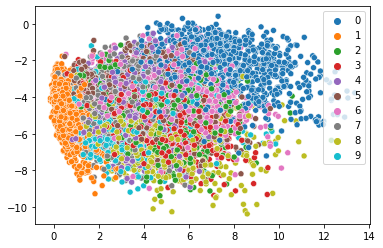

In [12]:
sns.scatterplot(x=projected[:,0], y=projected[:,1], 
    hue=[str(l) for l in labels], 
    hue_order=[str(i) for i in range(10)], legend="full")

In [13]:
def showEncodeDecode(encode_decode, x): 
    """ 
    encode_decode: the PyTorch Module that does the encoding and decoding 
    ➥ steps at once 
    x: the input to plot as is, and after encoding & decoding it 
    """

    encode_decode = encode_decode.eval()  
    encode_decode = encode_decode.cpu()  
    with torch.no_grad():                 
        x_recon = encode_decode(x.cpu()) 
    f, axarr = plt.subplots(1,2)         
    axarr[0].imshow(x.numpy()[0,:]) 
    axarr[1].imshow(x_recon.numpy()[0,0,:])

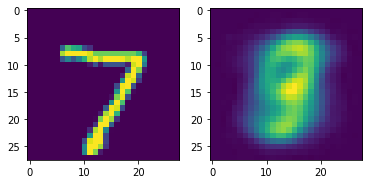

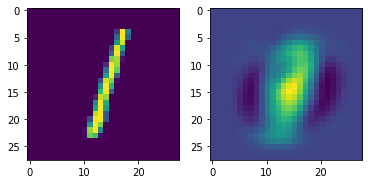

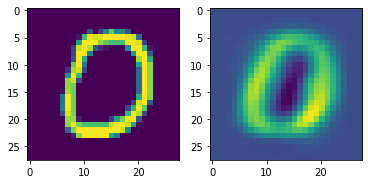

In [14]:
showEncodeDecode(pca_model, test_data_xy[0][0]) 
showEncodeDecode(pca_model, test_data_xy[2][0]) 
showEncodeDecode(pca_model, test_data_xy[10][0])

Small nonlinear PCA

In [15]:
pca_nonlinear_encode = nn.Sequential(  
    nn.Flatten(), 
    nn.Linear(D, n), 
    nn.Tanh(),                          
)

pca_nonlinear_decode = nn.Sequential(   
    nn.Linear(n, D),                   
    idlmam.View(-1, 1, 28, 28) 
) 
pca_nonlinear = nn.Sequential(         
    pca_nonlinear_encode, 
    pca_nonlinear_decode 
)

In [16]:
idlmam.train_network(pca_nonlinear, mse_loss, train_loader, 
    test_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,4.414106,0.132738,0.069905
1,1,8.321092,0.066680,0.065934
2,2,12.189436,0.065457,0.065291
3,3,16.118155,0.064728,0.064421
4,4,20.025166,0.063651,0.063011
5,5,23.920961,0.062036,0.061076
6,6,27.835635,0.060152,0.059259
7,7,31.775009,0.058722,0.058196
8,8,35.767845,0.057869,0.057497
9,9,39.859987,0.057375,0.057101


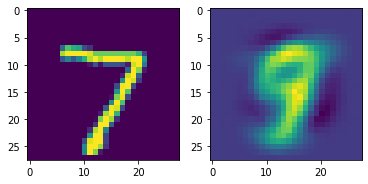

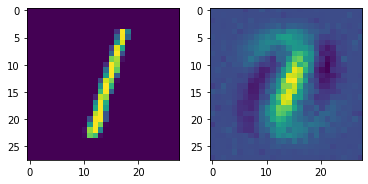

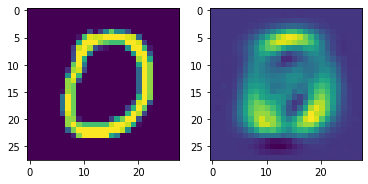

In [17]:
showEncodeDecode(pca_nonlinear, test_data_xy[0][0]) 
showEncodeDecode(pca_nonlinear, test_data_xy[2][0]) 
showEncodeDecode(pca_nonlinear, test_data_xy[10][0])